<a href="https://colab.research.google.com/github/PPM5658/AI_app/blob/main/Multi-object-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install ultralytics opencv-python-headless timm sentence-transformers faiss-cpu

In [34]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [35]:
print("Loading YOLOv8 model...")
model = YOLO('yolov8s.pt')
print("Model loaded successfully.")

Loading YOLOv8 model...
Model loaded successfully.


In [36]:
image_path = '/content/drive/MyDrive/Object tracking/Gemini_Generated_Image_6ewnwr6ewnwr6ewn.png'
try:
    frame = cv2.imread(image_path)
    if frame is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    print("Image loaded successfully.")
except Exception as e:
    print(e)

Image loaded successfully.


In [37]:
print("Running object detection...")
results = model(frame,conf=0.8,imgsz=1440)
print("Detection complete.")

Running object detection...

0: 1440x1440 2 cups, 1 bowl, 3 potted plants, 1 tv, 1 laptop, 1 keyboard, 64.5ms
Speed: 11.7ms preprocess, 64.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1440, 1440)
Detection complete.


Displaying results...


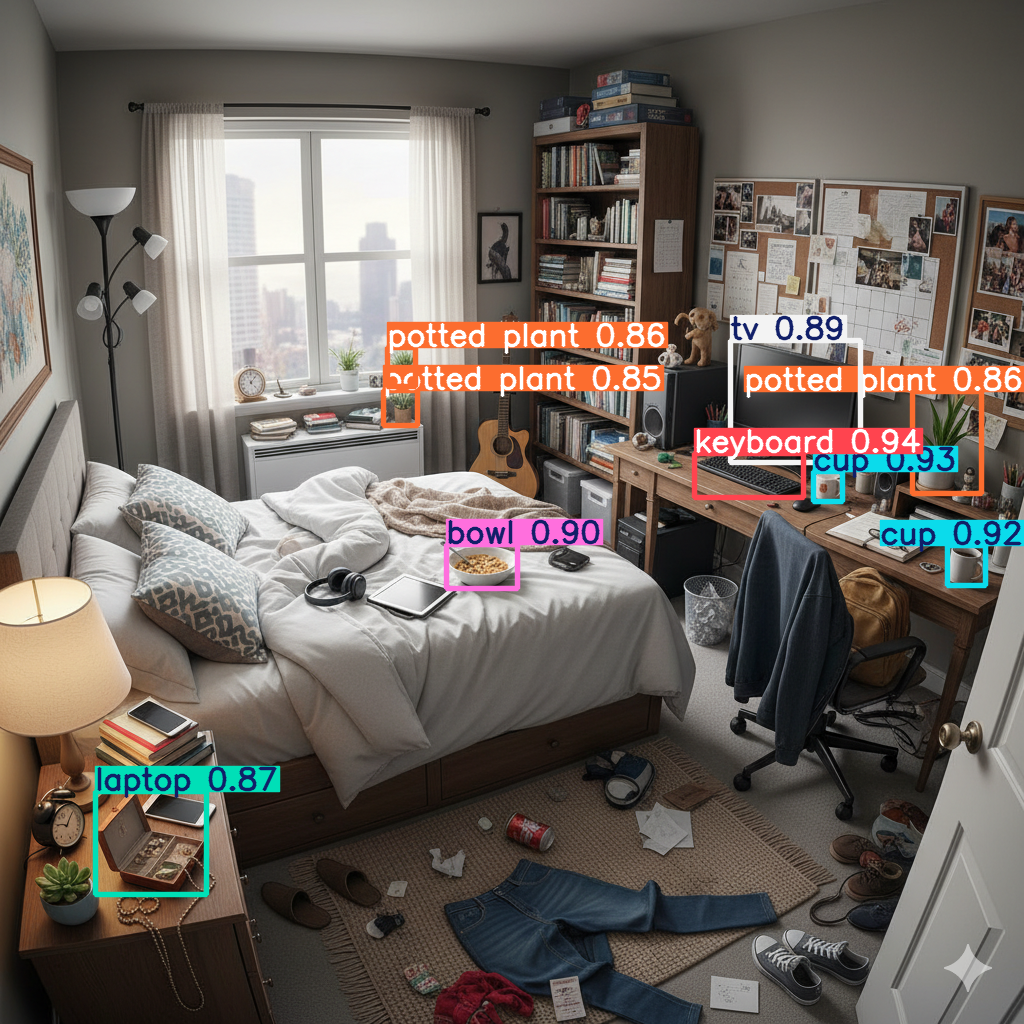

In [38]:
annotated_frame = results[0].plot()

print("Displaying results...")
cv2_imshow(annotated_frame)

Class names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone'

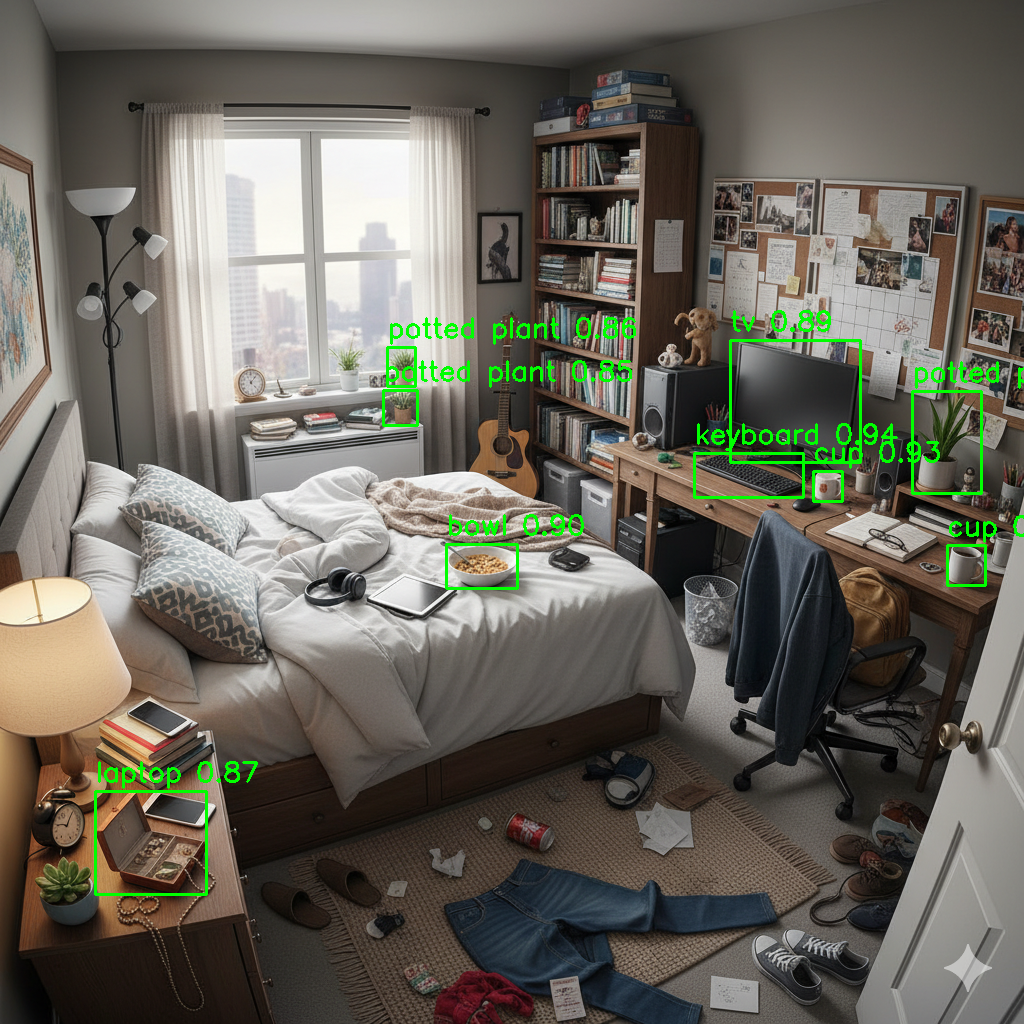

In [39]:
class_names = results[0].names
print(f"Class names: {class_names}\n")

print(f"Found {len(results[0].boxes)} objects in the image.")

for box in results[0].boxes:
    coords = box.xyxy[0].cpu().numpy().astype(int)
    x1, y1, x2, y2 = coords


    confidence = box.conf[0].cpu().numpy()

    class_id = int(box.cls[0].cpu().numpy())
    class_name = class_names[class_id]

    print(f"Object: {class_name} (ID: {class_id})")
    print(f"  - Confidence: {confidence:.2f}")
    print(f"  - Bounding Box: [x1:{x1}, y1:{y1}, x2:{x2}, y2:{y2}]")
    print("---")

    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(frame, f"{class_name} {confidence:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

cv2_imshow(frame)

In [41]:
video_path_in="/content/drive/MyDrive/Object tracking/test 2.mp4"
cap = cv2.VideoCapture(video_path_in)
if not cap.isOpened():
    print(f"Error: Could not open video file at {video_path_in}")

w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

print("Processing video frame by frame...")
frame_count = 0

Processing video frame by frame...


# Phase 2

In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [43]:
print('Loading Model Midas')
model_type="MiDaS_small"
midas=torch.hub.load('intel-isl/MiDaS',model_type)

device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
print('Model loaded successfully', device)

Loading Model Midas


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None
Model loaded successfully cuda


In [44]:
# Load transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

# Select transform based on model type
if model_type == "MiDaS_small":
    transform = midas_transforms.small_transform
else:
    transform = midas_transforms.dpt_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [45]:
frame=cv2.imread(image_path)
RGB=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
input_batch=transform(RGB).to(device)

In [46]:
print("Running inference...")
with torch.no_grad():
    prediction=midas(input_batch)

    prediction=torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=frame.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
depth_map=prediction.cpu().numpy()
print("Depth map generated successfully.")

Running inference...
Depth map generated successfully.


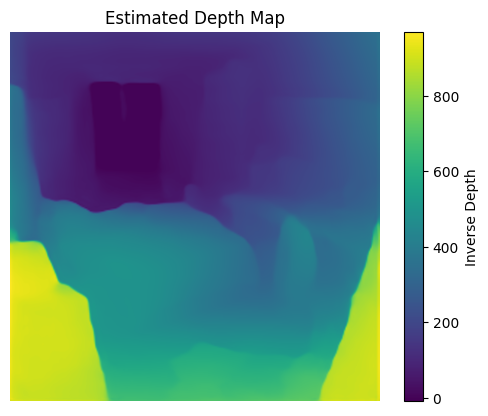

In [47]:
plt.imshow(depth_map, cmap='viridis')
plt.colorbar(label='Inverse Depth') # Add a color bar to show the scale
plt.title('Estimated Depth Map')
plt.axis('off')
plt.show()

Found 9 objects in the image.

Displaying results with manual drawings...


/tmp/ipython-input-880825521.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  distance_in_meters = 33/ depth_value


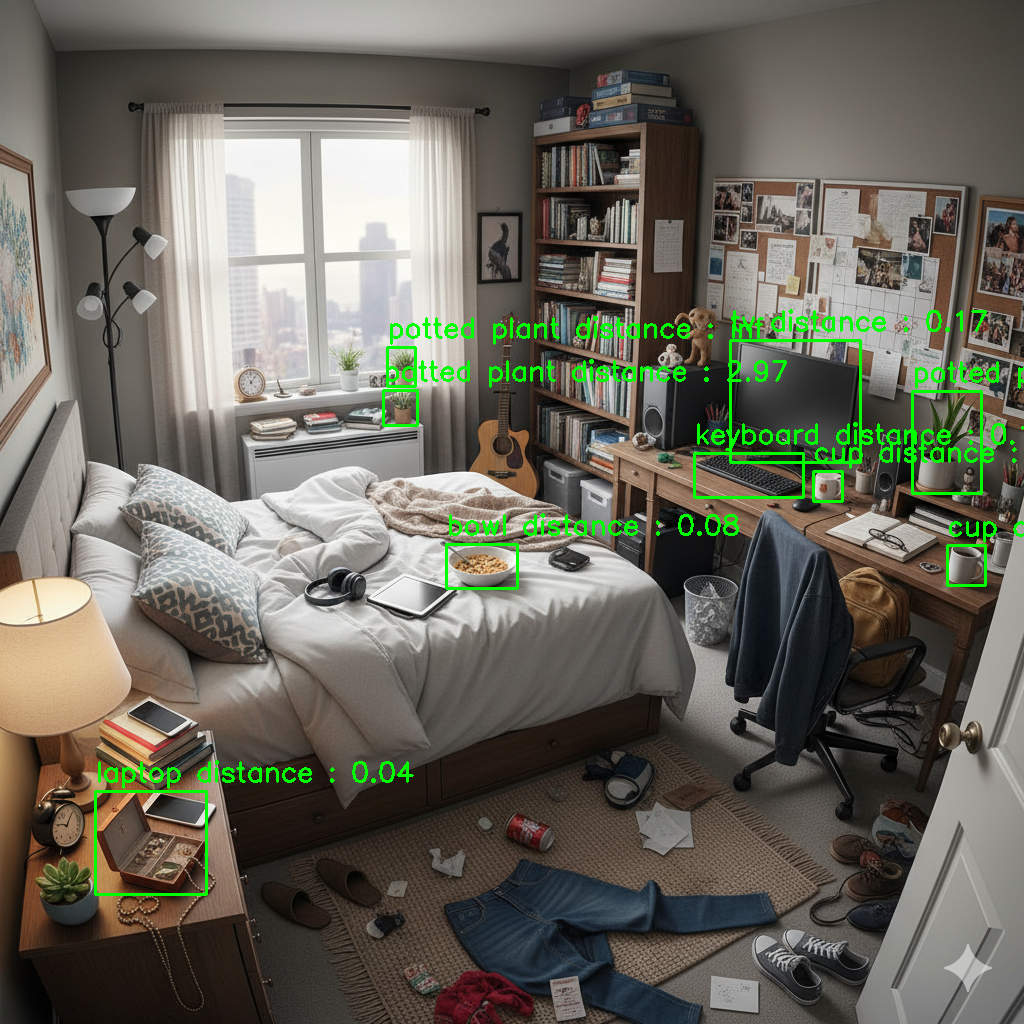

In [48]:
result = results[0]
class_names = result.names

print(f"Found {len(result.boxes)} objects in the image.")


for box in result.boxes:
    coords = box.xyxy[0].cpu().numpy().astype(int)
    x1, y1, x2, y2 = coords
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    start_x = max(center_x - 5, 0)
    end_x = min(center_x + 5, depth_map.shape[1])
    start_y = max(center_y - 5, 0)
    end_y = min(center_y + 5, depth_map.shape[0])
    depth_region = depth_map[start_y:end_y, start_x:end_x]
    depth_value = np.median(depth_region)

    confidence = box.conf[0].cpu().numpy()
    class_id = int(box.cls[0].cpu().numpy())
    class_name = class_names[class_id]
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    distance_in_meters = 33/ depth_value
    label_text = f"{class_name} distance : {distance_in_meters:.2f}"
    cv2.putText(frame, label_text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
print("\nDisplaying results with manual drawings...")
cv2_imshow(frame)

In [49]:
from sentence_transformers import SentenceTransformer

In [52]:
import cv2
import numpy as np
import torch
import faiss
from sentence_transformers import SentenceTransformer

class ObjectMemoryTracker:
    def __init__(self, model, midas, transform, device):
        self.model = model
        self.midas = midas
        self.transform = transform
        self.device = device
        self.em_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.memory_log = []
        self.known_ids = set()
        self.vector_database = None

    def process_frame(self, frame, timestamp):
        # Depth estimation
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_batch = self.transform(img_rgb).to(self.device)
        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1), size=img_rgb.shape[:2], mode="bicubic", align_corners=False
            ).squeeze()
        depth_map = prediction.cpu().numpy()

        # Object tracking
        results = self.model.track(frame, persist=True, conf=0.5)
        if results[0].boxes.id is None:
            return frame, self.memory_log  # No tracked objects

        boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
        track_ids = results[0].boxes.id.cpu().numpy().astype(int)
        class_ids = results[0].boxes.cls.cpu().numpy().astype(int)

        annotated_frame = frame.copy()
        closest_dist = float('inf')
        closest_box = None

        for box, track_id, class_id in zip(boxes, track_ids, class_ids):
            x1, y1, x2, y2 = box
            center_x, center_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            center_y = np.clip(center_y, 0, depth_map.shape[0] - 1)
            center_x = np.clip(center_x, 0, depth_map.shape[1] - 1)
            depth_value = depth_map[center_y, center_x]
            distance = 33 / depth_value if depth_value > 0 else float('inf')

            class_name = self.model.names[class_id]
            label = f"ID:{track_id} {class_name} | {distance:.2f}m"
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(annotated_frame, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

            if distance < closest_dist:
                closest_dist = distance
                closest_box = box

            if track_id not in self.known_ids:
                description = f"At {timestamp:.1f}s, a new object '{class_name}' (ID: {track_id}) appeared at {distance:.2f}m."
                self.memory_log.append(description)
                self.known_ids.add(track_id)

        if closest_box is not None:
            x1, y1, x2, y2 = closest_box
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 0, 255), 4)
            cv2.putText(annotated_frame, "Closest", (x1, y2 + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        return annotated_frame,self.memory_log

    def build_vector_database(self):
        embeddings = self.em_model.encode(self.memory_log)
        dim = embeddings.shape[1]
        self.vector_database = faiss.IndexFlatL2(dim)
        self.vector_database.add(embeddings.astype('float32'))
        return self.vector_database

    def query_memory(self, query_text, top_k=5):
        query_embedding = self.em_model.encode([query_text]).astype('float32')
        D, I = self.vector_database.search(query_embedding, top_k)
        return [self.memory_log[i] for i in I[0]]

In [53]:
cap = cv2.VideoCapture(video_path_in)
tracker=ObjectMemoryTracker(model,midas,transform,device)
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
    annotated = tracker.process_frame(frame, timestamp)

cap.release()

tracker.build_vector_database()
results = tracker.query_memory("person appeared near the camera")
for r in results:
    print(r)


0: 384x640 1 bottle, 1 remote, 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 remote, 10.9ms
Speed: 2.6ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 remote, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 remote, 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 remote, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 remote, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 remote, 1 cell phone, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 1 remote, 10.8ms
Speed: 2.5ms pr

In [ ]:
import faiss
import numpy as np

In [60]:
def answer_question(llm, tracker, question):

    print(f"\n🤔 User Question: \"{question}\"")
    print("looking through memories...")

    # 1. Retrieve context from the tracker's memory
    context = tracker.query_memory(question, top_k=5)
    context_string = "\n".join(context)

    print("Found relevant memories:")
    for mem in context:
        print(f"  - {mem}")

    # 2. Create the prompt for the LLM
    prompt = f"""
You are an AI assistant with a perfect memory of a video you just watched.
Your task is to answer the user's question. Use the following chronologically ordered facts from your memory as your primary source of truth.
Synthesize these facts into a helpful, conversational answer.
If the provided memory context does not contain enough information, state that you don't have a clear memory of that specific event.

--- MEMORY CONTEXT ---
{context_string}
--- END OF MEMORY ---

User Question: {question}

Answer:
"""

    try:
        print("\n🤖 Generating final answer with Gemini...")
        response = llm.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"❌ An error occurred while generating the answer: {e}")
        return "Sorry, I encountered an error while trying to generate a response."

In [62]:
import cv2
import torch
import google.generativeai as genai
from google.colab import userdata


print("🚀 Starting the Visual Memory System...")

# Configure Gemini API
llm = None
try:

    api_key = userdata.get('gemini') # Using Colab secrets
    genai.configure(api_key=api_key)
    llm = genai.GenerativeModel('gemini-2.5-flash')
    print("✅ Gemini API configured successfully.")
except Exception as e:
    print(f"❌ Error configuring Gemini API: {e}")

video_path = "/content/drive/MyDrive/Object tracking/test 3.mp4" # <--- SET YOUR VIDEO FILE PATH HERE
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"❌ Error: Could not open video file at {video_path}")

tracker = ObjectMemoryTracker(model, midas, transform, device)


print("\nProcessing video to build memory. This may take a moment...")
frame_count = 0
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
    # We process the frame, which internally calls _add_to_memory
    annotated_frame, memory_log = tracker.process_frame(frame, timestamp) # Capture memory_log

    frame_count += 1
cap.release()

print("\n✅ Video processing complete. Memory has been built.")

tracker.build_vector_database()
print("✅ Vector database built.")

print("\n========================================")
print("      Now you can ask questions!")
print("========================================")

if llm is not None:
    final_answer_1 = answer_question(llm, tracker, "What was the first thing you saw?")
    print("\nFinal Answer 1:\n", final_answer_1)
    print("-" * 30)

    final_answer_2 = answer_question(llm, tracker, "Was there a person in the video?")
    print("\nFinal Answer 2:\n", final_answer_2)
    print("-" * 30)

    final_answer_3 = answer_question(llm, tracker, "Did you see any laptops?")
    print("\nFinal Answer 3:\n", final_answer_3)
    print("-" * 30)
else:
    print("\nSkipping questioning as Gemini API was not configured.")

🚀 Starting the Visual Memory System...
✅ Gemini API configured successfully.

Processing video to build memory. This may take a moment...

0: 384x640 2 chairs, 10.9ms
Speed: 3.1ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 4 chairs, 1 dining table, 1 laptop, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 4 chairs, 1 dining table, 1 laptop, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 4 chairs, 1 dining table, 1 laptop, 10.8ms
Speed: 2.7ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 4 chairs, 1 dining table, 1 laptop, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 4 chairs, 1 dining table, 1 laptop, 10.9ms
Speed: 2.7ms preprocess

In [55]:
!pip install -q -U google-generativeai